# <center>SFML/INFO-F422: Statistical foundations of machine learning</center>

# <center>Regression Part</center>

Name: Mathieu Parmentier & Nilson Toula

Matricule: 000502042 & 000506378

Python version: 3.7

Date: 07/06/2020


## Introduction

In 1961, R.Bellman used for the first time the term of "curse of dimentionality" which can be refered as:  
>As the number of feature or dimension grows, the amount of data we need to generalize accurately grows exponentialy.

In this notebook we aim to study this effect by only focusiong on the variation in size of the training set in order to answer the question:

* **Is there a perfect training test size that allows us to correctly generalize any dataset?**



# Objective and strategy 

In this notebook we will study 2 diffent dataset:
 * Some **sythetic dataset** that while being simple will alows us to determine if our research question make sense in a controled environment.
 * A real dataset **Housing in london** (datasets_619175_1118179_housing_in_london_monthly_variables.csv)
 
We plan to use the synthetic dataset to identify candidate values for the size of our test set and formulate hypothesis, then we will try to apply thoose hypothesis on the real case dataset.

## Material and method

* First step: Finding accurate parameters  
Every algorithm having parameters, we will search a method that allows us to automatically choose correct parameters.  


* Second step: Comparing our algorithms  
We want to identify if for a given cross validation set, our algorithm perform in the same range.  
 
 
* Third step: Individual performances  
In this section we will identify how an algorithm perform individualy regarding some fixed percentages of the dataset in order to indentify a tendency.  


* Fourth step: Verification of our hypothesis using real dataset

### Synthetic datasets selection:

We decided to create two different dataset, they both don't have noise and are unidimention, the first one is a basic polynoma and the second is slithly more complex function with multiple local extrema.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

n_col = 1 #Number of dimentions of our dataset, we will keep it at 1 for our experimentations
n_row = 100 #Number of points in the dataset
np.random.seed(42)
X = np.random.random((n_row,n_col))
Y = np.ones(n_row)

#### Synhtetic dataset 1: $f(x) = x^3$

We chose a cubic function to generate our synthetic dataset. This function has only one variable and has not noise. This function, although basic, this function complex enought not to be linearly separable, beeing computed really fast by our algorithms.

In [3]:
for i in range(len(X)):
    X[i][0]=i-n_row/2
    Y[i]= (X[i][0])**3

#### Synhtetic data-set 2: $f(x) = ax^2 +b\sin (x)x$

This function is have a global parabola form but using parameter $b$ we can create several extrema, while parameter $a$ alows us to flatten the parabola, inducing even more similarities in the images, in other words:

* $a$ will influence horizontal distibutions of the points, the higher, the stiffer the parabola will be and the less similarities will occure
* $b$ will influence the depth of the parabola's local extremas, the higher, the deeper and stiffer local extrema will be

In [4]:
#Special parameters for Synthesis set 2:
a = 0.5 
b = 2 

for i in range(len(X)):
    X[i][0]=i-n_row/2
    Y[i]= a*(X[i][0])**2 + b*np.sin(X[i][0])*X[i][0] 

Now lets look at our dataset.

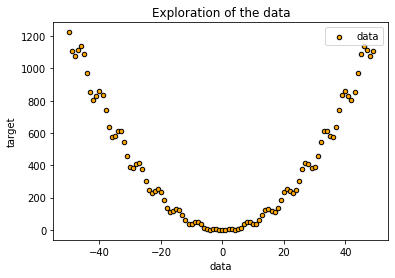

In [5]:
plt.figure()
plt.scatter(X[:,:1], Y, s=20, edgecolor="black",c="orange", label="data")

plt.xlabel("data")
plt.ylabel("target")
plt.title("Exploration of the data")
plt.legend()
plt.show()


### Importing libraries and splitting

We divide our data into a test set and a training set, and also load libraries shared by different algorithms and build a scoring function based on negative mean squared error to guide the optimization of our models.

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = .2, random_state = 25)

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import median_absolute_error, mean_squared_error
from sklearn.metrics import explained_variance_score, max_error, r2_score
import pandas as pd

 # I - Finding accurate parameters

### 1) Algorithm : $\epsilon$-Support vector machine regression

#### A) Introduction

The method of Support Vector Classification can be extended to solve regression problems. This method is called Support Vector Regression. The model produced by this method depend only on a subset of the training set.

  ##### 1. Theoretical approach
  
  Let $S= \{(x_n \in \mathbb{R}^d; y_n \in \mathbb{R} )  , n = 1, \dots, m \}$ be our training sample.
  Where $y_n$ is the numerical target value associated to the data-point $x_n$.
  
  

###### a. Linear $\epsilon$-SVR
 
  The epsillon-support vector regressor ($\epsilon$-SVR) finds a linear function of the form 
  $\begin{align} f: &\mathbb{R}^d &\rightarrow &\mathbb{R}\\
  &x &\rightarrow &w^Tx+b
  \end{align}$ 
  by constructing an $\epsilon$-insensitive tube, where aiming to reudce the risl of ovefitting, only object that lie outside the tube are penalized.
  This method solve the folowing Quadratic Programing problem:
  
  $$ \begin{align}
  min_{w,b,\xi,\xi^*} \text{      }& \frac{1}{2}\|w\|^2+(C\overrightarrow{1})^T(\xi+\xi^*) &\\
  s.t. \text{      } & y-((Aw)^T+b\overrightarrow{1})\leq \epsilon \overrightarrow{1}+ \xi &,\xi \geq 0\\
  & ((Aw)^T+b\overrightarrow{1}) - y \leq \epsilon \overrightarrow{1} + \xi^* &, \xi^* \geq 0
  \end{align}$$
  Where:  
  $A = [x_1 \dots x_n]^T \in \mathbb{R}^{m\times d}$,  
  $y = (y_1, \dots , y_n) \in \mathbb{R}^m$,  
  $ \overrightarrow{1} \in \mathbb{R}^m$ is the is a vector of ones,  
  $\xi$, $\xi^* \in \mathbb{R}^m$ are slack variables that penalize the sample that lie outside the $\epsilon$-insentive tube,  
  $C$  is the regularization factor that balances the trade-off between the fitting errors and the flatness of the linear regression function given by the minimization of the Euclidean norm of the weight vector $w$.

###### b. Extension of linear $\epsilon$-SVR using kernel method

Thanks to kernel trick, we can extend the linear $\epsilon$-SVR in non-linear datasets.

The kernel version of $\epsilon$-SVR is given by:
$$ \begin{align}
min_{\alpha, \alpha^*} \text{      }& \frac{1}{2}(\alpha - \alpha^*)^Tk(A,A^T)(\alpha - \alpha^*)+y^T(\alpha-\alpha^*)+ \epsilon \overrightarrow{1}^T (\alpha - \alpha^*)  \\
s.t.\text{      } & \overrightarrow{1}^T(\alpha - \alpha^*) = 0 \\
& 0 \leq \alpha , \alpha^* \leq C\overrightarrow{1}
\end{align}$$


Where $k(A,A^T)$ represents the matrix of kernel functions of the form $k_{ij} = \mathcal{K}(x_i,x_j)$  
$\mathcal{K} : \mathbb{R}^d \times \mathbb{R}^d \rightarrow \mathbb{R}$ is a kernel function,  
and $(\alpha, \alpha^*)$ are the dual variable vectors related with the constraint of section **a.**'s QP-problem.

###### c. Different kernel form
We will use an optimizer function that will choose the best kernel between two points of the training set $x_i$ and $x_j$

* Gaussian  
$\mathcal{K}(x_i,x_j) = exp\big(-\frac{ \|x_i-x_j \|^2}{2\sigma^2}\big)$ , with $\sigma > 0$ the kernel width parameter. 


* Polynomial  
$\mathcal{K}(x_i,x_j) = \langle x_i , x_j \rangle ^d$


* Radial Basis Function  (RBF)  
$\mathcal{K}(x_i,x_j) = f\big(d(x_i,x_j)\big)$ , where $f$ is a radial function (i.e. a real valued function whose value depends only on the distance between the data-points).


* sigmoid  
$\mathcal{K}(x_i,x_j) = tanh\big(ax_i^Tx_j+r\big)$, where $a>0$ can be viewed as a scaling parameter of the input data, and $r<0$ as a shifting parameter that control the treshold of mapping. 

<font color="gray"> Sources:</font> 
<br><br><font color="gray"> Abu-Mostafa, Yaser S., 1957-. (2012). Learning from data : a short course. [United States] :AMLBook.com, </font>
<br><br><font color="gray"> Scikit-Learn: https://scikit-learn.org/stable/modules/svm.html#svm-regression</font>
<br><br><font color="gray"> Carrasco, M., López, J., & Maldonado, S. (2019). Epsilon-nonparallel support vector regression. Applied Intelligence, 49(12), 4223-4236. </font> 
<br><br><font color="gray"> Schölkopf, B., Smola, A. J., & Bach, F. (2002). Learning with kernels: support vector machines, regularization, optimization, and beyond. MIT press. </font> 
<br><br><font color="gray"> wikipedia: https://en.wikipedia.org/wiki/Radial_basis_function </font> 
<br><br><font color="gray">Hsuan-tien, Lin, and Lin Chih-Jen. A Study on Sigmoid Kernels for SVM and the Training of Non-PSD Kernels by SMO-Type Methods. Technical repport, Version 3, 2003, https://citeseer.ist.psu.edu/viewdoc/summary?doi=10.1.1.14.6709.</font> 

#### B) Code

##### B-1) Default parameters

In [7]:
from sklearn.svm import SVR
import warnings

# Default parameters

svm_optimized = False

with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")

    # Default parameters
    svm_r = SVR()
    svm_r.fit(x_train, y_train)
    print("Our support vector with default parameters has an in-sample error equal to",np.sqrt(mean_squared_error(y_train, svm_r.predict(x_train))))
    print("Our support vector with default parameters has an out-sample error equal to",np.sqrt(mean_squared_error(y_test, svm_r.predict(x_test))))
    print()
    print("We can also compute the R², the explained variance score, the median absolute error and the maximum error for all the dataset")
    print("R²:",r2_score(Y, svm_r.predict(X)))
    print("Explained variance score :",explained_variance_score(Y, svm_r.predict(X)))
    print("Median absolute error :",median_absolute_error(Y, svm_r.predict(X)))
    print("Maximum error :",max_error(Y, svm_r.predict(X)))

Our support vector with default parameters has an in-sample error equal to 360.82464225741353
Our support vector with default parameters has an out-sample error equal to 412.8358352338825

We can also compute the R², the explained variance score, the median absolute error and the maximum error for all the dataset
R²: -0.003948713252887037
Explained variance score : 0.0061727317697336526
Median absolute error : 299.29116888753924
Maximum error : 845.7323144781953


##### B-2) Optimized parameters

In [8]:
with warnings.catch_warnings():
    # ignore all caught warnings
    #warnings.filterwarnings("ignore")
    
    print("Optimization of our model:")
    
    svm_optimized = True
    
    # Optimization test
    param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 10000, 100000], 'kernel':[ 'rbf', 'linear', 'sigmoid']}
    # Where C is Regularization parameter
    svm_ropt = GridSearchCV(SVR(gamma='scale'), param_grid, cv=5, verbose=0, n_jobs=-1)
    svm_ropt.fit(x_train, y_train)
    print('Optimized parameters:',svm_ropt.best_params_)
    svm_ropt = SVR(C = svm_ropt.best_params_['C'],kernel = svm_ropt.best_params_['kernel'], gamma='scale')
    svm_ropt.fit(x_train, y_train)
    print("Our support vector with optimized parameters has an in-sample error equal to",np.sqrt(mean_squared_error(y_train, svm_ropt.predict(x_train))))
    print("Our support vector with optimized parameters has an out-sample error equal to",np.sqrt(mean_squared_error(y_test, svm_ropt.predict(x_test))))
    print()
    print("We can also compute the R², the explained variance score, the median absolute error and the maximum error for all the dataset")
    print("R²:",r2_score(Y, svm_ropt.predict(X)))
    print("Explained variance score :",explained_variance_score(Y, svm_ropt.predict(X)))
    print("Median absolute error :",median_absolute_error(Y, svm_ropt.predict(X)))
    print("Maximum error :",max_error(Y, svm_ropt.predict(X)))
    

Optimization of our model:
Optimized parameters: {'C': 10000, 'kernel': 'rbf'}
Our support vector with optimized parameters has an in-sample error equal to 43.6205070082566
Our support vector with optimized parameters has an out-sample error equal to 43.14177370179135

We can also compute the R², the explained variance score, the median absolute error and the maximum error for all the dataset
R²: 0.9862421046695329
Explained variance score : 0.986255647601105
Median absolute error : 23.980944948541943
Maximum error : 117.80144749601732


##### Plot of the results:

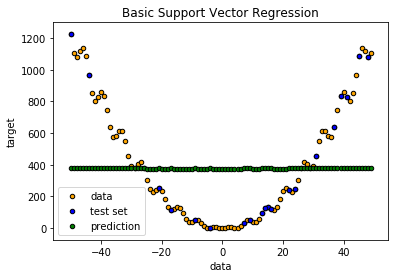

The model parameters: SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)


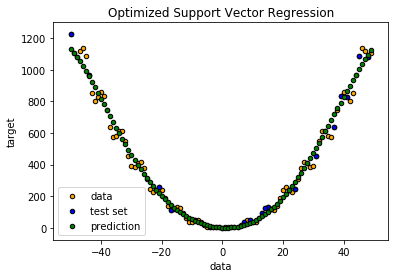

The model parameters: SVR(C=10000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [9]:
plt.figure()
plt.scatter(X[:,:1], Y, s=20, edgecolor="black",c="orange", label="data")
plt.scatter(x_test[:,:1], y_test, s=20, edgecolor="black",c="blue", label="test set")
plt.scatter(X[:,:1], svm_r.predict(X), s=20, edgecolor="black",c="green", label="prediction")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Basic Support Vector Regression")
plt.legend()
plt.show()

print("The model parameters:",svm_r)


if svm_optimized :
    plt.figure()
    plt.scatter(X[:,:1], Y, s=20, edgecolor="black",c="orange", label="data")
    plt.scatter(x_test[:,:1], y_test, s=20, edgecolor="black",c="blue", label="test set")
    plt.scatter(X[:,:1], svm_ropt.predict(X), s=20, edgecolor="black",c="green", label="prediction")
    plt.xlabel("data")
    plt.ylabel("target")
    plt.title("Optimized Support Vector Regression")
    plt.legend()
    plt.show()

    print("The model parameters:",svm_ropt)




##### Discussion:
With all the parameters we tried for our sythetic dataset, we noted that optimization was performing better than the defaults parameters.

Throught try and error, we found that C is the most important parameter, most of the time, a high C paired with RBF kernel perform better than other alternatives.  
We were also optimising with a polynomial kernel, but the processing time with higher C were note reasonable while being most of the time outperformed by either (high C, RBF kernel) or (Low C, sigmoid kernel), thus we choose to skip it in our optimization set, while keeping the others to keep generality.

### 2) Algorithm : Decision Tree Regression 

#### A) Introduction
>Decision tree are a non-parametric supervised learning method used for classification and regression. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.

Decision tree regression is an algorithm based on Frequency Table to develop a tree from the root to the leafs.  
This method is really similar to Decision Tree Classifier, the processing of the data is the same except that instead of Information Gain, the output will be Standard Deviation Reduction.
The goal is to create the most homogenous branches (i.e. minimize the Coefficient of Variation for every branches).

  ##### 1. The problem
  
  Given a training set with $N$ observations of $x_{m} \in \mathbb{R}^d $ where $x_m = (x_{m1}, \dots, x_{md})$,  
  we want to create regions  $\{R\}_{m=1}^M$ that minimize the mean sample error (MSE), where:
$$min_{MSE}\big(\{R\}_{m=1}^M\big) \sim min_{\{R\}_{m=1}^M}\big(\frac{1}{N_m}\sum_{i\in R_m}(y_i - \bar{y_m})^2 \big)$$

The only issue is that this problem is NP-Hard, for exemple, having $N=50$ and $M=5$ $\Rightarrow$ $\binom{50}{5} > 2 \times 10^6$

  ##### 2. A solution
  We do not want to iterate on every possible group, so we decide to only groups on *hypercubes* using a recursive binary split method.
  
  To do so, we use a greedy algorithm iterating 3 steps:
   * For each variable $x_k$ ,we find a candidate that will be the optimal cutoff point $s$ such that: $min_s \big[MSE(y_i \mid x_{ik} <s) + MSE(y_i \mid x_{ik} \geq s)\big]$.
   * Then, we chose tha value $k$ yelling the candidate with the lowest MSE.
   * Finaly, we add s as a node and iterate until MSE-gain become too small or if all branches have a leave.
   
   
   ##### 3. Improvement methods
   We can impove the fit with hyperparameters such as:
   * increasing the max number of split
   * imposing a minimum number of observation per leaves
   * imposing a maximum depth for the tree
  
  

<font color="gray"> Main source:</font>  
<font color="gray"> University of copenhag, departement of economics, Big data, lecture 21 - N.Anders Munk, 2016 </font>

<font color="gray"> Other sources:</font>  
<font color="gray"> StatQuest with Josh Starmer: Regression Trees, Clearly Explained!!!</font>  
<font color="gray"> Scikit-Learn: https://scikit-learn.org/stable/modules/tree.html#regression </font>
  

#### B) Code

In [10]:
from sklearn.tree import DecisionTreeRegressor


# Default parameters
DTR = DecisionTreeRegressor()
DTR.fit(x_train, y_train)


print("Our DecisionTreeRegressor with default parameters has an in-sample error equal to",np.sqrt(mean_squared_error(y_train, DTR.predict(x_train))))
print("Our DecisionTreeRegressor with default parameters has an out-sample error equal to",np.sqrt(mean_squared_error(y_test, DTR.predict(x_test))))
print("Explained variance score with default parameters:",explained_variance_score(Y, DTR.predict(X)))
print()

print("Optimization of our model:")


# Optimization test
param_grid = {"criterion": ["mse", "mae"],"max_depth": [2, 3, 4, 8, 10, 20],"min_samples_split": [2, 3, 5, 8, 10, 20, 40],"min_samples_leaf": [2, 5, 10, 15, 20, 40, 100],"max_leaf_nodes": [2, 5, 10,15, 20,40, 100]}
DTR_opt = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, verbose=0)
DTR_opt.fit(x_train, y_train)
print('Optimized parameters:',DTR_opt.best_params_)
DTR_opt = DecisionTreeRegressor(criterion = DTR_opt.best_params_['criterion'],max_depth = DTR_opt.best_params_['max_depth'],min_samples_split = DTR_opt.best_params_['min_samples_split'],min_samples_leaf = DTR_opt.best_params_['min_samples_leaf'],max_leaf_nodes = DTR_opt.best_params_['max_leaf_nodes'])
DTR_opt.fit(x_train, y_train)
print("Our DecisionTreeRegressor with optimized parameters has an in-sample error equal to",np.sqrt(mean_squared_error(y_train, DTR_opt.predict(x_train))))
print("Our DecisionTreeRegressor with optimized parameters has an out-sample error equal to",np.sqrt(mean_squared_error(y_test, DTR_opt.predict(x_test))))
print()
#print("We can also compute the R², the explained variance score, the median absolute error and the maximum error for all the dataset")
print("R²:",r2_score(Y, DTR_opt.predict(X)))
print("Explained variance score :",explained_variance_score(Y, DTR_opt.predict(X)))
print("Median absolute error :",median_absolute_error(Y, DTR_opt.predict(X)))
print("Maximum error :",max_error(Y, DTR_opt.predict(X)))

Our DecisionTreeRegressor with default parameters has an in-sample error equal to 0.0
Our DecisionTreeRegressor with default parameters has an out-sample error equal to 58.62538357650477
Explained variance score with default parameters: 0.9951335731966152

Optimization of our model:
Optimized parameters: {'criterion': 'mse', 'max_depth': 10, 'max_leaf_nodes': 40, 'min_samples_leaf': 2, 'min_samples_split': 2}
Our DecisionTreeRegressor with optimized parameters has an in-sample error equal to 25.56020194411469
Our DecisionTreeRegressor with optimized parameters has an out-sample error equal to 77.15760282531733

R²: 0.9875574651903103
Explained variance score : 0.9876951488175769
Median absolute error : 14.798330865030877
Maximum error : 177.81874643646222


##### Plot of the results:

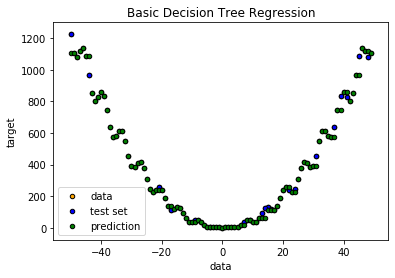

The model parameters: DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')


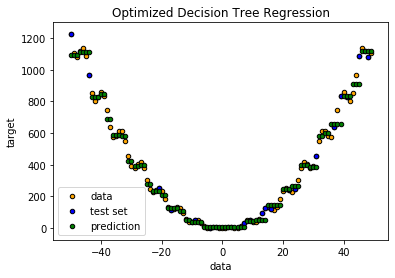

The model parameters: DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                      max_leaf_nodes=40, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')


In [11]:

plt.figure()
plt.scatter(X[:,:1], Y, s=20, edgecolor="black",c="orange", label="data")
plt.scatter(x_test[:,:1], y_test, s=20, edgecolor="black",c="blue", label="test set")
plt.scatter(X[:,:1], DTR.predict(X), s=20, edgecolor="black",c="green", label="prediction")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Basic Decision Tree Regression")
plt.legend()
plt.show()
print("The model parameters:",DTR)


plt.figure()
plt.scatter(X[:,:1], Y, s=20, edgecolor="black",c="orange", label="data")
plt.scatter(x_test[:,:1], y_test, s=20, edgecolor="black",c="blue", label="test set")
plt.scatter(X[:,:1], DTR_opt.predict(X), s=20, edgecolor="black",c="green", label="prediction")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Optimized Decision Tree Regression")
plt.legend()
plt.show()
print("The model parameters:",DTR_opt)



##### Discussion:
On every sythesis dataset parameter we tested, our method of optimization seem to be less reliable on DTR than the default parameters.

We had two hypothesis regarding this result:  
* Our scoring method is not suited to corectly evaluate DTR.
* DTR's parameter space is too big for our method of optimization, thus it stays stuck in a local optima.


Let study the case with the parameters:
* $f(x) = 0.5x^2 + 2sin(x)x$
* $seed = 42$
* $N = 100  $  
In this case, we can note that the only difference between the optimised parameters and the defaults ones are min_sample_leaf parameter which are respectively set to 2 and 1.  
This parameter represents the minimum number of node for a set of points to be considered as a leaf, while in the one hand this value is set to 1, some leafs will be perfect nodes inducing a lower Biais, in the other hand, having at least twice as much leave for one node will force a bigger biais and theoriticaly reduce the variance.  

But this exemple show us that a bigger bias and less overfitting not always result in an increased performance regarding generalisation.


### 3) Algorithm : Neural network Regression  

#### A) Introduction
An artificial neural network is an algorithm based on a biomimetic of the interactions of the neurons in the brain of leaving creatures.

  ##### - Theoretical approach
  
  As its name stand, a neural network can be represented as a graph, we can identify 3 different layers:
   * Input layer: It will take a vector $x_n \in \mathbb{R}^d$ as an input and transfer values to the hidden layer linked to the coefficients $x_{ni}$ according to activations functions of its neurons.
   * Hidden layer: We call the hidden layer any layer between the input and the output layer. All neurons from those layers answer to an activation function that we will present you a little further.
   * Output layer: It will sum all the activations values (a) from the last hidden layer which has been multiplied by their linked weight (w) together and add an extra bias value (b).
  
######  a) How does that work?
  
  Let $S= \{(x_n \in \mathbb{R}^d; y_n \in \mathbb{R} )  , n = 1, \dots, m \}$ be our training sample.
  Where $y_n$ is the numerical target value associated to the data-point $x_n$.
  
  
  Let's pick $(x_1, y_1)$, the first data-point that we put in the first neuron of the input layer.
  
  It's activation function look like: $a_1^0 = x_1$ where 0 is number of the layer and 1 stand for the first neuron.
  
  We set like that all the n neurons of the input layer.
  
  Then the first neuron of the hidden layer plays its part. It retrieves all the activation values of the neurons of the previous layer to calculate its own activation function as:
  
$Z_1^1 = (w_1^1 * a_1^0 + w_2^1 * a_2^0 + ... + w_n^1 * a_n^0) + b_1^1$
 
$a_1^1 = g^1(Z_1^1)$ where g is a hyperbolic tan by default in our algorithm.
  
  All the neurons from the hidden layers will be set like that with the activation values from the previous neurons layer.
  
  There is only one neuron in the output layer but it will follow the same activation rule as the neurons from the hidden layer except for the last step:
  
$a_1^{\text{output layer}}= Z_1^{\text{output layer}}$ For the output layer $g$ is the identity function.

  ###### b) Backpropagation
  
  The loss function can be written as,
  
  $Loss(\hat {y},y,W) = \frac{1}{2}\|\hat {y}-y\|_2^2+\frac{\alpha}{2}\|w\|_2^2$ where $\alpha$ is a non-negative hyperparameter.
  
  In our case, we do a gradient descent as:
  
  $W^{i+1} = W^{i} - \epsilon \nabla Loss_w^i$ where $\epsilon$ and i are the learning rate and the iteration step respectively.
  
  

<font color="gray"> Sources:</font>  
<font color="gray"> Scikit-Learn: https://scikit-learn.org/stable/modules/neural_networks_supervised.html#neural-networks-supervised </font>  
<font color="gray">Toward datascience: https://towardsdatascience.com/machine-learning-for-beginners-an-introduction-to-neural-networks-d49f22d238f9 </font>  
<font color="gray">3blue1Brown, Grant Sanderson: https://youtu.be/tIeHLnjs5U8 </font>

#### B) Code

In [12]:
from sklearn.neural_network import MLPRegressor
import warnings

# Default parameters

with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    
    NNR = MLPRegressor()
    NNR.fit(x_train, y_train)
    print("Our DecisionTreeRegressor with default parameters has an in-sample error equal to",np.sqrt(mean_squared_error(y_train, NNR.predict(x_train))))
    print("Our DecisionTreeRegressor with default parameters has an out-sample error equal to",np.sqrt(mean_squared_error(y_test, NNR.predict(x_test))))
    print()
    print("Optimization of our model:")
    
    # Optimization test
    param_grid = {"hidden_layer_sizes": [(i,i) for i in range(1,25)], "alpha": [0.00005,0.0001,0.0005],"activation" : ['logistic', 'tanh', 'relu']}
    NNR_opt = GridSearchCV(MLPRegressor(solver = "lbfgs"), param_grid, cv=5, verbose=0)
    NNR_opt.fit(x_train, y_train)
    print('Optimized parameters:',NNR_opt.best_params_)
    NNR_opt = MLPRegressor(hidden_layer_sizes = NNR_opt.best_params_['hidden_layer_sizes'],alpha = NNR_opt.best_params_['alpha'],activation = NNR_opt.best_params_['activation'], solver = "lbfgs")
    NNR_opt.fit(x_train, y_train)
    
    #param_grid = {"hidden_layer_sizes": [(i,i) for i in range(1,25)], "alpha": [0.00005,0.0001,0.0005], "learning_rate" : ['constant', 'invscaling','adaptive'],"activation" : ['logistic', 'tanh', 'relu']}
    #NNR_opt = GridSearchCV(MLPRegressor(solver = "lbfgs"), param_grid, cv=5, verbose=0)
    #NNR_opt.fit(x_train, y_train)
    #print('The optimize settings are',NNR_opt.best_params_)
    #NNR_opt = MLPRegressor(hidden_layer_sizes = NNR_opt.best_params_['hidden_layer_sizes'],alpha = NNR_opt.best_params_['alpha'],learning_rate = NNR_opt.best_params_['learning_rate'],activation = NNR_opt.best_params_['activation'], solver = "lbfgs")
    #NNR_opt.fit(x_train, y_train)
    
    
    
    
print("Our support vector with optimized parameters has an in-sample error equal to",np.sqrt(mean_squared_error(y_train, NNR_opt.predict(x_train))))
print("Our support vector with optimized parameters has an out-sample error equal to",np.sqrt(mean_squared_error(y_test, NNR_opt.predict(x_test))))

print()
#print("We can also compute the R², the explained variance score, the median absolute error and the maximum error for all the dataset")
print("R²:",r2_score(Y, NNR_opt.predict(X)))
print("Explained variance score :",explained_variance_score(Y, NNR_opt.predict(X)))
print("Median absolute error :",median_absolute_error(Y, NNR_opt.predict(X)))
print("Maximum error :",max_error(Y, NNR_opt.predict(X)))

Our DecisionTreeRegressor with default parameters has an in-sample error equal to 439.717905705127
Our DecisionTreeRegressor with default parameters has an out-sample error equal to 481.07321249843693

Optimization of our model:
Optimized parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (15, 15)}
Our support vector with optimized parameters has an in-sample error equal to 44.0461708023162
Our support vector with optimized parameters has an out-sample error equal to 39.19649545903982

R²: 0.9864971274475173
Explained variance score : 0.9866089616714246
Median absolute error : 27.849021732137764
Maximum error : 118.39976085571266


##### Plot of the results:

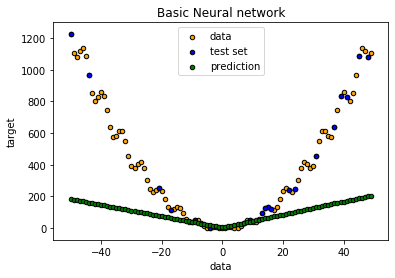

The model parameters: MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)


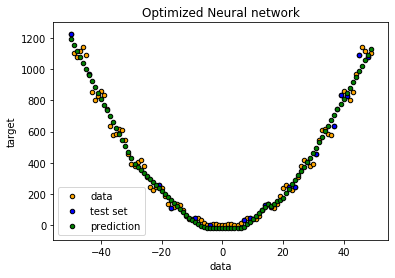

The model parameters: MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(15, 15), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)


In [13]:
plt.figure()
plt.scatter(X[:,:1], Y, s=20, edgecolor="black",c="orange", label="data")
plt.scatter(x_test[:,:1], y_test, s=20, edgecolor="black",c="blue", label="test set")
plt.scatter(X[:,:1], NNR.predict(X), s=20, edgecolor="black",c="green", label="prediction")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Basic Neural network")
plt.legend()
plt.show()
print("The model parameters:",NNR)


plt.figure()
plt.scatter(X[:,:1], Y, s=20, edgecolor="black",c="orange", label="data")
plt.scatter(x_test[:,:1], y_test, s=20, edgecolor="black",c="blue", label="test set")
plt.scatter(X[:,:1], NNR_opt.predict(X), s=20, edgecolor="black",c="green", label="prediction")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Optimized Neural network")
plt.legend()
plt.show()
print("The model parameters:",NNR_opt)

#####  Discussion:
We can notice that the architecture of the Neural Network plays a key role on determining how the data are proceeded.
But since this algorithm is a black bow, we can hardly indentify the main parameters that have the most influence on the result.

For exemple, the parameters:
* $f(x) = 0.5x^2 + 2sin(x)x$
* $seed = 42$
* $N = 100  $  
We can notice that the choosen architecture for the hidden layers (15,15) and using lbfgs as solver, is much more efficient than the default one (100,) with an adam solver.
Though, we can notice that the neural network is getting some of the complexity of $f$ by not beeing totally convex for the values close from zero.

### 4) Algorithm : K Nearest neighbors regression

#### A) Introduction
k-Nearest Neighbors regressor is a neighbors based algorithm (i.e. an algorithm approximating a data-point's value based on the mean value of data-points in its topological's neighbourhood). 

##### 1. theoretical approach

* Let $f : \mathbb{R}^d \rightarrow \mathbb{R}$ be a function and let $S = \{(x_1,y_1),\dots,(x_n,y_n)\}$ observations of $f$ be our training set. Without loss of generality, lets assume that $x_1$ and $x_n$ are respectively upper and lower range of the $x_i$ values.  

* **interpolation of a testing point $x_j \in [x_1,x_n]$**  
Let $\mathcal{B}$ be the smallest ball such that $\mathcal{B}$ contain at least $k$ training data-points.  
To compute $y_j$ we will take the mean of all the values of the data-points included in $\mathcal{B}$, formally:
$$y_j = \frac{1}{ N_{\mathcal{B}} }\sum_{i, \forall x_i \in \mathcal{B} } y_i$$ , where $N_{\mathcal{B}}$ is the number of points other than $x_j$ in $\mathcal{B}$

##### 2. discussion

* **How can we choose $k$?**  
On the one hand, if $k$ is too low, we have an high risk of overfit and our algorithm will be too sensitive to outlayers.  
On the other hand, if $k$ is too big, we will not be precise enought to coreclty interpolate our point. Especially if $k=n$, returned value will be the mean of our training set regardless of the test point we try to evaluate.

Thus, we can use cross-validation in order to compute a adequate $k$.

* **Which distance should I we use to compute $\mathcal{B}$?**  
Most of the time, we use the Euclidian distance:  $ d(x_n, x_j) = \sqrt{ \sum_d \mid x_{nd} - x_{jd} \mid^2 }$  
But this distance is very sensitive to extreme values and can only be applyed on numeric attributes.

However, we can generalise this distance an take $p$-norm (or Minkowski distance) which have a free parameter $p$.  
$ d(x_n, x_j) = \sqrt[p]{ \sum_d \mid x_{nd} - x_{jd} \mid^p }$, with $p=1$ we have the Manhattan distance and with $p=2$ we have the Euclidian distance, depending of the value of $p$, this distance can have various propierty that can help have a better exploitation of our model.

NB: For non numerical features we can use various other distances such as Hamming distances for qualitative distances, BM25 for text, or Kullback-Leibler distance for histograms, most of general metric functions can be applied with this algorithm.


##### 3. Alternatives, Issues and Improvements
* Breacking a tie  
There is several methods to breack a tie: 
  - Flip a coin
  - Use the closest higher or lower $k$
  - choose the class with greater prior
  - etc..
  
* Missing values  
As we are computing distances, we have to compute any missing values, then we can use the mean of the missing datas.

* Weighted means
We can use weighted means in order for the nearest data-point to have a greater effect on the mean by using the invert of the distance as a weight.



<font color="gray"> Main source:</font>  
<font color="gray"> Victor Lavrenko and Nigel Goddard - Introductory Applied Machine Learning- School of Informatics, University of Eidinburgh </font>

<font color="gray"> Other sources:</font>  
<font color="gray"> University of Utah - Machine learning course  </font>  
<font color="gray"> StatQuest with josh Stamer: https://youtu.be/HVXime0nQeI  </font>  
<font color="gray"> Udacty, SL4 - Intance based learning https://www.udacity.com/ </font>  

In [14]:
from sklearn import neighbors


# Default parameters
knn = neighbors.KNeighborsRegressor()
knn.fit(x_train, y_train)


print("Our DecisionTreeRegressor with default parameters has an in-sample error equal to",np.sqrt(mean_squared_error(y_train, knn.predict(x_train))))
print("Our DecisionTreeRegressor with default parameters has an out-sample error equal to",np.sqrt(mean_squared_error(y_test, knn.predict(x_test))))
print()
print("Optimization of our model:")


# Optimization test
param_grid = {"n_neighbors": [2,3,4,5,6,7,8,9],"leaf_size": [2,5,10,20,30,50,100], "weights": ["uniform", "distance"], "metric": ["euclidean", "manhattan"]}
knn_opt = GridSearchCV(neighbors.KNeighborsRegressor(), param_grid, cv=5, verbose=0)
knn_opt.fit(x_train, y_train)
print('Optimized parameters:',knn_opt.best_params_)
knn_opt = neighbors.KNeighborsRegressor(n_neighbors = knn_opt.best_params_['n_neighbors'],leaf_size = knn_opt.best_params_['leaf_size'],weights = knn_opt.best_params_['weights'],metric = knn_opt.best_params_['metric'])
knn_opt.fit(x_train, y_train)
print("Our support vector with optimized parameters has an in-sample error equal to",np.sqrt(mean_squared_error(y_train, knn_opt.predict(x_train))))
print("Our support vector with optimized parameters has an out-sample error equal to",np.sqrt(mean_squared_error(y_test, knn_opt.predict(x_test))))
print()
#print("We can also compute the R², the explained variance score, the median absolute error and the maximum error for all the dataset")
print("R²:",r2_score(Y, knn_opt.predict(X)))
print("Explained variance score :",explained_variance_score(Y, knn_opt.predict(X)))
print("Median absolute error :",median_absolute_error(Y, knn_opt.predict(X)))
print("Maximum error :",max_error(Y, knn_opt.predict(X)))

Our DecisionTreeRegressor with default parameters has an in-sample error equal to 35.074057828963404
Our DecisionTreeRegressor with default parameters has an out-sample error equal to 54.64431670572599

Optimization of our model:
Optimized parameters: {'leaf_size': 2, 'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'distance'}
Our support vector with optimized parameters has an in-sample error equal to 0.0
Our support vector with optimized parameters has an out-sample error equal to 37.88339129772194

R²: 0.9979155162547027
Explained variance score : 0.9979558355487377
Median absolute error : 0.0
Maximum error : 126.32517043891653


##### Plot of the results:

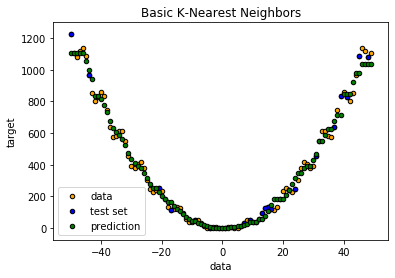

The model parameters: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')


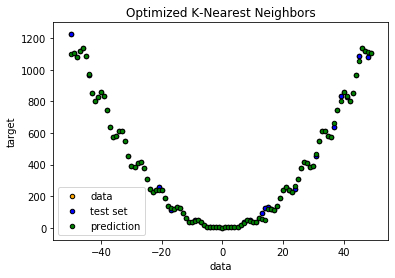

The model parameters: KNeighborsRegressor(algorithm='auto', leaf_size=2, metric='euclidean',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='distance')


In [15]:
plt.figure()
plt.scatter(X[:,:1], Y, s=20, edgecolor="black",c="orange", label="data")
plt.scatter(x_test[:,:1], y_test, s=20, edgecolor="black",c="blue", label="test set")
plt.scatter(X[:,:1], knn.predict(X), s=20, edgecolor="black",c="green", label="prediction")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Basic K-Nearest Neighbors")
plt.legend()
plt.show()
print("The model parameters:",knn)



plt.figure()
plt.scatter(X[:,:1], Y, s=20, edgecolor="black",c="orange", label="data")
plt.scatter(x_test[:,:1], y_test, s=20, edgecolor="black",c="blue", label="test set")
plt.scatter(X[:,:1], knn_opt.predict(X), s=20, edgecolor="black",c="green", label="prediction")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Optimized K-Nearest Neighbors")
plt.legend()
plt.show()
print("The model parameters:",knn_opt)

##### Discussion:
k-NN perform surprisingly well, and once again we note a improvement with optimized parameters.

For Synthetic Dataset-2 (a= 0.5, b=2, seed=42, N=100)
We can notice that almost all parameters have been changed in the optimization process, but, the optimized version capture the details of the function particularly well compared to all other algorithms.

## Part 1 - Conclusion

In this section we wanted to know if there were a way to automaticaly change our algorithm's parameters in order to improve them. Using two different sythetic dataset and changing the parameters, we notice that at the exception of the Decision-Tree, there was a sinificative improvement of the generalization after optimization.

We can then easily suppose that parameter optimization is a good way to adapt our algorithms to unknown datasets.

# II - Comparing our algorithms

We tried to optimize our algorithms the best that we can. Now, we would like to compare our models between each other to know  if their is sinificative differences in the quality of there output.  

Using $R^2$-means applyed on cross-validation, we want to see if thoose algorithm's perforlances, knowing that:  
$$ R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2} $$, where $\bar{y} = \frac{1}{n} \sum_{i=1}^{n} y_i$ is the mean of the outputs and $\sum_{i=1}^{n} (y_i - \hat{y}_i)^2 = \sum_{i=1}^{n} \epsilon_i^2$ is the residual variance.


* Procedure

For a fixed dataset, we will evaluate our algorithms with several partitioning size as $CV$ for the cross-validation method.

According to Scikit-Learn, the method used for this cross validation will be K-Folds.

K-Folds cross-validator:
> Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).
>Each fold is then used once as a validation while the k - 1 remaining folds form the training set.

In [16]:
from sklearn.linear_model import LinearRegression

linr = LinearRegression()
linr.fit(x_train, y_train)

models = [linr,svm_ropt,DTR,DTR_opt,NNR_opt,knn_opt]
models_label = ['Linear regression','SVR','DTR(Basic)','DTR(Optimized)','Neural network','K-Nearest Neighbors']

cv = [2,3,4,5,6,8,10,20]
R2 = []
Fittime = [] 

with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    for j in cv:
        R2_cv = []
        fittime_cv = []
        for i in range(len(models)):
            score = cross_validate(models[i], X, Y, cv=j)
            R2_cv.append(np.mean(score['test_score']))
            fittime_cv.append(np.mean(score['fit_time']))
            
        R2.append(R2_cv)
        Fittime.append(fittime_cv)

header = models_label
table = R2
print()
print('R²-mean of all models for different cv:')
pd.DataFrame(table, columns = header,index = cv)


R²-mean of all models for different cv:


,Linear regression,SVR,DTR(Basic),DTR(Optimized),Neural network,K-Nearest Neighbors
2,-13.972139,0.387798,-1.245367,-1.236895,-1.090890,-1.237016
3,-58.923651,0.247816,-2.159221,-2.119267,-0.955141,-2.366828
4,-19.626209,-0.503477,-1.882404,-2.286448,0.374400,-2.173227
5,-151.444196,-0.225346,-1.584206,-1.702092,-1.830766,-1.809146
6,-40.748325,0.877349,-0.677580,-0.906848,0.680372,-0.814087
8,-123.696986,0.114399,-2.177676,-2.730753,-0.426870,-2.603950
10,-134.508994,0.725787,-0.652061,-0.968412,0.307950,-0.633248
20,-6031.364593,-4.371465,-8.210489,-18.469685,-6.471927,-13.408277


* Meaning of those values:
  -  $R²$ = 1, means that our predictions are always accurate, it is the best possible value.
  -  $R²$ = 0, means that our prediction are as acurate than the mean of the observed data.
  -  $R²$ $\leq$ 0 means that the residual variance os larger than the data variance (i.e. the observed mean is better than our predicator)
  
  
* Interpretation
Even if every model is dominating the Linear regressor, we can note that exept for SV-R and Neural network, our models' $R²$ values are globaly negatives with no order of similarities whatsoever.

We can then conclude with no surprise than our models have no similatities one to another and thus our objective of identify a "perfect training set size" is probably compromised... However, we can still probably determine a range where our algorithms are performing well even if that range is proper to the algorithm.

In [17]:
header = models_label
table = Fittime 
print()
print('Time of fit for all models in function of cv:')
pd.DataFrame(table, columns = header,index = cv)


Time of fit for all models in function of cv:


,Linear regression,SVR,DTR(Basic),DTR(Optimized),Neural network,K-Nearest Neighbors
2,0.002494,0.004987,0.000999,0.000498,0.123195,0.000998
3,0.000996,0.004986,0.000997,0.000998,0.152926,0.000667
4,0.001238,0.006483,0.000750,0.000998,0.146621,0.000750
5,0.001189,0.003990,0.000598,0.000599,0.136455,0.000798
6,0.000994,0.006815,0.000997,0.000665,0.160413,0.000666
8,0.000872,0.004986,0.000623,0.000623,0.139755,0.000624
10,0.000798,0.007779,0.000798,0.000997,0.117184,0.000599
20,0.000698,0.006282,0.000848,0.000449,0.138031,0.000753


The goal of this table was to identify if an algorithm was dominan in regard of its result and its processing time.

We can note that at the exception of **Neural Network** that is dominated by **SV-R** and **Linear regressor** dominated by both **Decision trees**, no algorithm dominate overall.


# III - How the size of the training set influance the algorithm efficiency 

Thanks to **Part II**, we now know that there is nothing like "a perfect training set size", however, we can still try to identify a "global range" where results are interesting, or, in the worst case, a "range proper to every algorithm". And finaly, we could at least expect to identify "no go range", where algorithms do not perfom correctly...


First of all, we start by creating a **measurement function** that will help us extract datas from our functions for a large range of test size.
Those range are from 5% of the total dataset up to 95% representing the **percentage of the test set**.



In [18]:
def measurement(model,test_size,X,Y):
    ''' Measure the training efficiency for a particular training size'''
    measure = []
    for i in range(len(test_size)):
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = test_size[i], random_state = 25)
        model.fit(x_train, y_train)
        E_in = np.sqrt(mean_squared_error(y_train, model.predict(x_train)))
        E_out = np.sqrt(mean_squared_error(y_test, model.predict(x_test)))
        EV = explained_variance_score(Y, model.predict(X))
        R2 = model.score(X,Y)
        ME = median_absolute_error(Y, model.predict(X))
        MAE = max_error(Y, model.predict(X))
        measure.append([E_in,E_out,EV,R2,ME,MAE])
    return measure
 

test_size = [0.05,0.1,0.15,0.2,0.25,0.33,0.4,0.5,0.7,0.9,0.95] #Represent the proportion of the dataset to include in the train split.
stat = ['E_in','E_out','EV','R²','ME','MAE']
resume = []

In [19]:
header = stat
table = measurement(linr,test_size,X,Y)
print()
print('Linear regression error for different training size:')
pd.DataFrame(table, columns = header,index = test_size)


Linear regression error for different training size:


,E_in,E_out,EV,R²,ME,MAE
0.05,375.126613,282.954085,0.001413,0.000083,331.179300,769.002163
0.10,368.426032,394.455080,-0.000111,-0.000181,322.593924,775.095536
0.15,366.613442,394.091141,0.001251,0.001145,320.603751,796.980931
0.20,359.461099,414.564639,-0.000043,-0.000320,319.348397,777.645773
0.25,366.491173,384.490170,0.000032,0.000025,326.301897,769.920488
0.33,367.230676,380.989717,-0.004046,-0.004046,328.647629,792.530432
0.40,362.333521,393.426836,-0.018497,-0.021690,317.852449,853.901195
0.50,381.170368,366.635792,-0.014473,-0.015671,316.332089,836.774647
0.70,386.609067,367.244272,-0.005599,-0.011252,336.743169,770.758165
0.90,361.108993,410.883109,-0.169376,-0.198142,292.877641,1058.541845


* Linear regression error:  
Those values of the Linear Regressor will be used as a lower bound/benshmark for our algorithms.

In [20]:
   
    header = stat
    table = measurement(svm_ropt,test_size,X,Y)
    print()
    print('Support Vector Machine (Regression) error for different training size:')
    pd.DataFrame(table, columns = header,index = test_size)


Support Vector Machine (Regression) error for different training size:


,E_in,E_out,EV,R²,ME,MAE
0.05,41.547610,31.356932,0.987735,0.987734,23.857709,116.687629
0.10,41.537056,38.170256,0.987902,0.987665,27.241062,104.884307
0.15,42.693928,41.927911,0.986873,0.986833,26.087360,118.086474
0.20,43.620507,43.141774,0.986256,0.986242,23.980945,117.801447
0.25,43.951478,45.622483,0.985721,0.985700,22.657407,121.003159
0.33,42.805036,48.421503,0.985467,0.985466,21.751160,123.971905
0.40,40.472510,54.457950,0.984396,0.984248,19.502496,123.365146
0.50,40.092075,50.824156,0.984890,0.984784,22.359142,127.407309
0.70,42.074091,45.919948,0.985498,0.985424,23.738522,136.816932
0.90,37.817475,61.698243,0.974645,0.974081,25.040681,191.987768


* Support Vector Machine:  
At the exception of a clear case of overfiting at 95% (while still being dominan in regard to the LR), **SVM** is prety consistant in the range  **[5% ; 70%]**.
We can also note that those results seems of a very good.

In [21]:
header = stat
table = measurement(DTR_opt,test_size,X,Y)
print()
print('Decision Tree Regression error for different training size:')
pd.DataFrame(table, columns = header,index = test_size)


Decision Tree Regression error for different training size:


,E_in,E_out,EV,R²,ME,MAE
0.05,25.117848,18.629070,0.995521,0.995521,15.725205,59.761774
0.10,24.392559,53.485834,0.994037,0.994034,16.058056,145.465153
0.15,22.758222,58.618282,0.993080,0.993060,14.392344,145.829470
0.20,25.560202,77.157603,0.987695,0.987557,14.798331,177.818746
0.25,25.570105,80.248737,0.984748,0.984747,15.725205,177.818746
0.33,24.706878,69.654072,0.985447,0.985403,15.204453,177.818746
0.40,20.030934,66.889612,0.985255,0.985255,15.725205,210.764368
0.50,21.379941,66.557265,0.982256,0.982255,19.160180,190.547279
0.70,50.310863,88.524469,0.954718,0.954648,34.102475,217.080034
0.90,222.361813,243.503399,0.577508,0.576546,120.193916,681.598877


* Decision Tree Regression:
We can identify a concistancy in the **[5% ; 50%]** range, however our results are still good even at 70%, this is maybe pointing to a brutal drop of performance as seen with the SVM passed 90%.

In [22]:
header = stat
with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    table = measurement(NNR_opt,test_size,X,Y)
print()
print('Neural network Regression error for different training size:')
pd.DataFrame(table, columns = header,index = test_size)


Neural network Regression error for different training size:


,E_in,E_out,EV,R²,ME,MAE
0.05,42.403629,33.715660,0.987254,0.987182,30.907136,101.592680
0.10,40.353916,39.315857,0.988244,0.988234,25.630897,95.609318
0.15,41.626608,37.112845,0.987830,0.987803,30.693180,99.668968
0.20,41.566431,37.771456,0.988107,0.987890,31.210999,103.744695
0.25,41.697323,41.424153,0.987419,0.987415,26.506295,112.033942
0.33,47.815207,57.979174,0.981220,0.980819,33.945089,160.275104
0.40,38.471678,49.963388,0.986315,0.986299,26.000460,130.509388
0.50,38.721712,52.144709,0.984693,0.984682,28.583234,117.380093
0.70,42.771957,56.578352,0.980600,0.979741,34.900521,160.061262
0.90,47.032025,65.010441,0.974098,0.970770,36.203396,177.317730


* Neural network Regression:
Orverall result of the NN are really good, by only picking the best cheries, we can identify a consistancy zone in the rage **[5% ; 25%]** that we can easily extend to the range [5% ; 90%]

In [23]:
header = stat
table = measurement(knn_opt,test_size,X,Y)
print()
print('K Nearest neighbors error for different training size:')
pd.DataFrame(table, columns = header,index = test_size)


K Nearest neighbors error for different training size:


,E_in,E_out,EV,R²,ME,MAE
0.05,0.0,14.598985,0.999923,0.999923,0.000000,21.195898
0.10,0.0,19.684610,0.999719,0.999719,0.000000,33.609508
0.15,0.0,38.754000,0.998379,0.998364,0.000000,126.325170
0.20,0.0,37.883391,0.997956,0.997916,0.000000,126.325170
0.25,0.0,41.066941,0.996944,0.996938,0.000000,126.325170
0.33,0.0,42.718032,0.995657,0.995627,0.000000,126.325170
0.40,0.0,46.353270,0.993759,0.993758,0.000000,136.817951
0.50,0.0,50.135416,0.990993,0.990873,0.309171,136.817951
0.70,0.0,61.563667,0.980845,0.980733,17.001698,190.289441
0.90,0.0,127.005484,0.898174,0.894571,40.542236,404.040170


* k-Nearest Neighbors:
Logically, we can notice a constant improvement of the results as the number of point in the training set increase. 
Once in the range **[5% ; 50%]**, the overall results are pretty good, while not stopping improving in term of **E_out**.

### Discusion


# IV - Application on a real dataset

In [28]:
data = pd.read_csv('datasets_619175_1118179_housing_in_london_monthly_variables.csv')

data = data.dropna()

print("The data's dimension are", data.shape)
print('The features of the data are: ', list(data.columns))

The data's dimension are (7375, 7)
The features of the data are:  ['date', 'area', 'average_price', 'code', 'houses_sold', 'no_of_crimes', 'borough_flag']


Let's explore our data

The correlation matrix shows the average price in function of all variables:
houses_sold     -0.305322
no_of_crimes     0.109721
average_price    1.000000
borough_flag          NaN
Name: average_price, dtype: float64


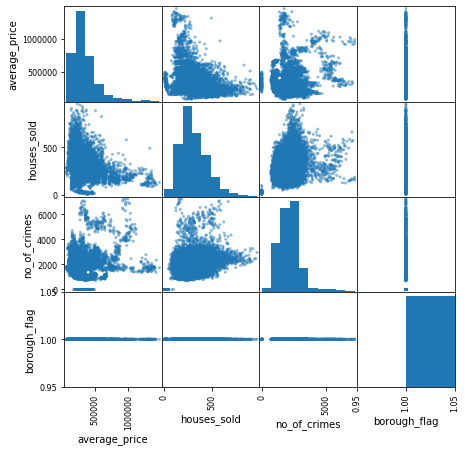

In [29]:
from pandas.plotting import scatter_matrix

with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    corr_matrix = data.corr()
    print('The correlation matrix shows the average price in function of all variables:')
    print(corr_matrix['average_price'].sort_values())

    scatter_matrix(data[list(data.columns)], figsize=[len(list(data.columns)),len(list(data.columns))])
    plt.show()

Let's build our regression model

In [41]:
Yd = data['average_price']
Xd = data['houses_sold']

Yd = np.array(Yd)
Xd = np.array(Xd)
Xd.resize((len(Xd),1))

with warnings.catch_warnings():
    # ignore all caught warnings
    warnings.filterwarnings("ignore")
    
    #Split set
    xd_train, xd_test, yd_train, yd_test = train_test_split(Xd, Yd, test_size = 0.25, random_state = 25)
    
    #linr
    linrd = LinearRegression()
    linrd.fit(xd_train, yd_train)
    
    #SVMR
    param_grid = {'C': [ 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'kernel':[ 'rbf', 'linear', 'sigmoid']}
    svm_roptd = GridSearchCV(SVR(), param_grid, cv=5, verbose=0, n_jobs=-1)
    svm_roptd.fit(xd_train, yd_train)
    svm_roptd_param = SVR(C = svm_roptd.best_params_['C'],kernel = svm_roptd.best_params_['kernel'], gamma='scale')
    
    #DTR
    param_grid = {"criterion": ["mse", "mae"],"max_depth": [2, 3, 4, 8, 10, 20],"min_samples_split": [2, 3, 5, 8, 10, 20, 40],"min_samples_leaf": [2, 5, 10, 15, 20, 40, 100],"max_leaf_nodes": [2, 5, 10,15, 20,40, 100]}
    DTR_optd = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, verbose=0, n_jobs=-1)
    DTR_optd.fit(xd_train, yd_train)
    DTR_optd_param = DecisionTreeRegressor(criterion = DTR_optd.best_params_['criterion'],max_depth = DTR_optd.best_params_['max_depth'],min_samples_split = DTR_optd.best_params_['min_samples_split'],min_samples_leaf = DTR_optd.best_params_['min_samples_leaf'],max_leaf_nodes = DTR_optd.best_params_['max_leaf_nodes'])
    
    #NNR
    param_grid = {"hidden_layer_sizes": [(i,i) for i in range(1,25)], "alpha": [0.00005,0.0001,0.0005],"activation" : ['logistic', 'tanh', 'relu']}
    NNR_optd = GridSearchCV(MLPRegressor(solver = "lbfgs"), param_grid, cv=5, verbose=0, n_jobs=-1)
    NNR_optd.fit(xd_train, yd_train)
    NNR_optd_param = MLPRegressor(hidden_layer_sizes = NNR_optd.best_params_['hidden_layer_sizes'],alpha = NNR_optd.best_params_['alpha'],activation = NNR_optd.best_params_['activation'], solver = "lbfgs")
    
    #Knn
    param_grid = {"n_neighbors": [2,3,4,5,6,7,8,9],"leaf_size": [2,5,10,20,30,50,100], "weights": ["uniform", "distance"], "metric": ["euclidean", "manhattan"]}
    knn_optd = GridSearchCV(neighbors.KNeighborsRegressor(), param_grid, cv=5, verbose=0, n_jobs=-1)
    knn_optd.fit(xd_train, yd_train)
    knn_optd_param = neighbors.KNeighborsRegressor(n_neighbors = knn_optd.best_params_['n_neighbors'],leaf_size = knn_optd.best_params_['leaf_size'],weights = knn_optd.best_params_['weights'],metric = knn_optd.best_params_['metric'])
    
    summary_r2 = [linrd.score(xd_test, yd_test),svm_roptd.score(xd_test, yd_test),DTR_optd.score(xd_test, yd_test),NNR_optd,knn_optd.score(xd_test, yd_test)]

In [42]:
print(summary_r2[3])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                    batch_size='auto', beta_1=0.9, beta_2=0.999,
                                    early_stopping=False, epsilon=1e-08,
                                    hidden_layer_sizes=(100,),
                                    learning_rate='constant',
                                    learning_rate_init=0.001, max_iter=200,
                                    momentum=0.9, n_iter_no_change=10,
                                    nesterovs_momentum=True, power_t=0.5,
                                    random_stat...
             param_grid={'activation': ['logistic', 'tanh', 'relu'],
                         'alpha': [5e-05, 0.0001, 0.0005],
                         'hidden_layer_sizes': [(1, 1), (2, 2), (3, 3), (4, 4),
                                                (5, 5), (6, 6), (7, 7), (8, 8),
                                        

In [43]:
"""
def measurement(model,test_size,X,Y):
    # Measure the training efficiency for a particular training size
    measure = []
    for i in range(len(test_size)):
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = test_size[i], random_state = 25)
        model.fit(x_train, y_train)
        E_in = np.sqrt(mean_squared_error(y_train, model.predict(x_train)))
        E_out = np.sqrt(mean_squared_error(y_test, model.predict(x_test)))
        EV = explained_variance_score(Y, model.predict(X))
        R2 = model.score(X,Y)
        ME = median_absolute_error(Y, model.predict(X))
        MAE = max_error(Y, model.predict(X))
        measure.append([E_in,E_out,EV,R2,ME,MAE])
    return measure
"""

'\ndef measurement(model,test_size,X,Y):\n    # Measure the training efficiency for a particular training size\n    measure = []\n    for i in range(len(test_size)):\n        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = test_size[i], random_state = 25)\n        model.fit(x_train, y_train)\n        E_in = np.sqrt(mean_squared_error(y_train, model.predict(x_train)))\n        E_out = np.sqrt(mean_squared_error(y_test, model.predict(x_test)))\n        EV = explained_variance_score(Y, model.predict(X))\n        R2 = model.score(X,Y)\n        ME = median_absolute_error(Y, model.predict(X))\n        MAE = max_error(Y, model.predict(X))\n        measure.append([E_in,E_out,EV,R2,ME,MAE])\n    return measure\n'

In [44]:
header = stat
table = measurement(linrd,test_size,Xd,Yd)
print()
print('Linear regression error for different training size:')
pd.DataFrame(table, columns = header,index = test_size)


Linear regression error for different training size:


,E_in,E_out,EV,R²,ME,MAE
0.05,178692.598747,189928.596632,0.093221,0.093205,101209.515021,1.045976e+06
0.10,178871.905628,182829.820182,0.093218,0.093201,101265.393348,1.045701e+06
0.15,179800.114133,176237.789868,0.093222,0.093221,101616.560220,1.045434e+06
0.20,179315.888998,179101.135440,0.093193,0.093191,101381.845748,1.044356e+06
0.25,179202.605588,179477.203429,0.093214,0.093207,101956.770200,1.044220e+06
0.33,179527.387884,178750.274523,0.093208,0.093208,101665.850744,1.044367e+06
0.40,180756.311549,177026.056452,0.093211,0.093185,102027.661671,1.045197e+06
0.50,182039.160768,176493.773984,0.093221,0.093043,102854.297342,1.043026e+06
0.70,178974.034957,179429.940842,0.093032,0.092985,102326.404706,1.047447e+06
0.90,184522.205629,178698.500842,0.093080,0.093029,100960.217124,1.049636e+06


In [45]:
header = stat
table = measurement(svm_roptd,test_size,Xd,Yd)
print("The model parameters:",svm_roptd_param)
print()
print('Support Vector Machine (Regression) error for different training size:')
pd.DataFrame(table, columns = header,index = test_size)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The model parameters: SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Support Vector Machine (Regression) error for different training size:


,E_in,E_out,EV,R²,ME,MAE
0.05,186807.478310,201404.185466,0.079897,0.007366,82869.935294,1.120175e+06
0.10,187204.335895,193416.898964,0.079113,0.004501,82489.454430,1.121697e+06
0.15,188230.471054,185016.935035,0.079752,0.005388,82718.505466,1.120961e+06
0.20,187593.332089,188396.263781,0.079747,0.005360,82722.691444,1.120974e+06
0.25,187333.585597,187451.648245,0.080712,0.009500,82909.604097,1.118855e+06
0.33,187787.181158,187353.716971,0.079455,0.006525,82882.895215,1.120768e+06
0.40,188639.571853,184353.018892,0.082854,0.014003,83238.180840,1.115622e+06
0.50,190077.508303,183481.634994,0.082786,0.015358,83317.847368,1.115187e+06
0.70,186338.165412,186020.625096,0.085512,0.022642,83877.778261,1.110079e+06
0.90,194082.416300,188469.154838,0.079268,-0.008284,81233.560000,1.125822e+06


In [46]:
header = stat
table = measurement(DTR_optd,test_size,Xd,Yd)
print("The model parameters:",DTR_optd_param)
print()
print('Decision Tree Regression error for different training size:')
pd.DataFrame(table, columns = header,index = test_size)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The model parameters: DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=10, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=15,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

Decision Tree Regression error for different training size:


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,E_in,E_out,EV,R²,ME,MAE
0.05,175508.966113,187676.698319,0.124643,0.124631,93827.555008,1.057080e+06
0.10,175866.212390,179743.493069,0.123446,0.123435,93924.365231,1.061432e+06
0.15,176502.366184,174028.663297,0.124675,0.124675,94797.602837,1.061072e+06
0.20,176196.620729,176585.813230,0.123274,0.123271,94568.492347,1.061099e+06
0.25,175977.595476,177220.139836,0.123127,0.123126,94814.498305,1.061060e+06
0.33,176177.145455,176631.430305,0.122747,0.122747,94202.477581,1.040658e+06
0.40,177358.270290,174715.888840,0.122976,0.122957,94555.132824,1.060676e+06
0.50,178338.466318,174636.249395,0.121203,0.121058,94330.441426,1.060616e+06
0.70,174893.046694,177337.000086,0.120053,0.119955,93804.905707,1.062297e+06
0.90,179656.521869,177878.191297,0.105570,0.105453,92407.462733,1.071095e+06


In [49]:
header = stat
with warnings.catch_warnings():
    #ignore all caught warnings
    warnings.filterwarnings("ignore")
    table = measurement(NNR_optd,test_size,Xd,Yd)
print("The model parameters:",NNR_optd_param)
print()
print('Neural network Regression error for different training size:')
pd.DataFrame(table, columns = header,index = test_size)

The model parameters: MLPRegressor(activation='relu', alpha=0.0005, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(19, 19), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

Neural network Regression error for different training size:


,E_in,E_out,EV,R²,ME,MAE
0.05,178692.598747,189928.596002,0.093221,0.093205,101209.507364,1.045976e+06
0.10,178213.133327,181930.537890,0.100161,0.100101,100660.995559,1.050635e+06
0.15,178876.774998,175490.343132,0.102277,0.102277,98183.577512,1.061772e+06
0.20,178491.664770,178293.181090,0.101480,0.101477,101410.090769,1.048363e+06
0.25,179200.067011,179476.768068,0.093235,0.093228,101968.749988,1.044234e+06
0.33,178673.052392,178034.395127,0.101371,0.101371,98460.190189,1.065823e+06
0.40,179717.989389,176257.722280,0.102600,0.102585,98493.882292,1.056988e+06
0.50,180855.483323,175678.431940,0.103392,0.103154,99418.506062,1.047725e+06
0.70,176355.469900,177420.595817,0.115244,0.115022,98280.136991,1.080711e+06
0.90,184412.701672,178770.823486,0.092511,0.092486,101558.898074,1.051937e+06


In [50]:
header = stat
table = measurement(knn_optd,test_size,Xd,Yd)
print("The model parameters:",knn_optd_param)
print()
print('K Nearest neighbors error for different training size:')
pd.DataFrame(table, columns = header,index = test_size)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


The model parameters: KNeighborsRegressor(algorithm='auto', leaf_size=10, metric='euclidean',
                    metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                    weights='uniform')

K Nearest neighbors error for different training size:


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,E_in,E_out,EV,R²,ME,MAE
0.05,174301.419220,192047.553057,0.133642,0.133610,90675.666667,1.080972e+06
0.10,173907.331674,192232.989708,0.128114,0.127715,88821.333333,1.081139e+06
0.15,173600.665305,186732.063014,0.129771,0.129627,90112.666667,1.008635e+06
0.20,173423.220396,186659.387618,0.124527,0.124509,92052.222222,1.085822e+06
0.25,172835.883031,187497.633470,0.120043,0.119871,92633.777778,1.089261e+06
0.33,172384.253582,187475.547772,0.111026,0.110970,92121.000000,1.095321e+06
0.40,171989.325927,184442.319217,0.115300,0.115284,91829.333333,1.110685e+06
0.50,170318.030550,186958.644470,0.097903,0.097635,93650.333333,1.100244e+06
0.70,166033.527338,185649.720846,0.086006,0.085914,95047.111111,1.122682e+06
0.90,170594.002195,190040.102483,0.000781,0.000767,95258.111111,1.119427e+06


### Discusion

## Conclusion 

## Bibliography

 Lecture + ...

regression validation: https://dziganto.github.io/cross-validation/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-with-Validation-and-Cross-Validation/
regression validation : https://scikit-learn.org/stable/modules/model_evaluation.html

#####################################################"
https://www.youtube.com/watch?v=Gol_qOgRqfA
